In [79]:
import pandas as pd
import numpy as np
import lifelines as sa
from lifelines import KaplanMeierFitter
#from lifelines.datasets import load_waltons
import os
import sys
#import math
#import struct
#import pandas as pd
#import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt
#import numpy as np
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()
#from bokeh.plotting import figure, show#, output_file

Loading BokehJS ...

In [80]:
TEST = True
DATA_DIR = "data/"
#DATA_FOLDERS = ["2014","2015","data_Q1_2016","data_Q2_2016","data_Q3_2016","data_Q4_2016"]
DATA_FOLDERS = ["data_Q1_2016","data_Q2_2016"]
#THE_TIME = strftime("%Y-%m-%d-%H-%S", gmtime())
SUMMARY_DIR = "summary_data/"
PERCENT_TOTAL_REQ = .05
INPUT_DIR = "survival_data"

In [81]:
target_models = []
for df in DATA_FOLDERS:
    print(SUMMARY_DIR + df + '.csv')
    summary_dats = pd.read_csv(SUMMARY_DIR + df + '.csv', header=0, nrows=200)
    #print(temp.head)
    summary_dats = summary_dats.sort_values(by="percent_total", ascending=False)
    clipped = summary_dats[summary_dats['percent_total'] >= PERCENT_TOTAL_REQ]
    #print(clipped)
    #target_models.append(clipped['model'])
    [target_models.append(m) for m in clipped['model']]
    
#print(np.unique(target_models))

unique_target_models = np.unique(target_models)
print(unique_target_models)

summary_data/data_Q1_2016.csv


IOError: File summary_data/data_Q1_2016.csv does not exist

In [82]:
#unique_target_models[0]
#dat = DATA_FOLDERS[0]
dtmp = 'survival_ST4000DM000data_Q2_2016.csv'
#dtmp = 'survival_HGST_HMS5C4040BLE640data_Q2_2016.csv'
#dtmp = 'survival_Hitachi_HDS5C3030ALA630data_Q2_2016.csv'
print(INPUT_DIR + "/" + dtmp)
survival = pd.read_csv(INPUT_DIR + "/" + dtmp, header=0)#,nrows=50) # my laptop is struggling to handle more rows


survival_data/survival_ST4000DM000data_Q2_2016.csv


IOError: File survival_data/survival_ST4000DM000data_Q2_2016.csv does not exist

In [43]:
print(survival.head())
km = sa.KaplanMeierFitter()
km.fit(durations=survival['runtime_max'], event_observed=survival['failure'])#, entry=survival['runtime_min'])
S = km.survival_function_

  serial_number  runtime_max  runtime_min  uptime  n_obs  failure
0      S3000FZ5      12895.0       8551.0  4344.0    182        0
1      S3000NSV      12799.0       8456.0  4343.0    182        0
2      S3000QAP      12991.0       8648.0  4343.0    182        0
3      S30015PW       9925.0       5582.0  4343.0    182        0
4      S3001FPA       6564.0       2221.0  4343.0    182        0


AttributeError: '_process_plot_var_args' object has no attribute 'color_cycle'

56.0


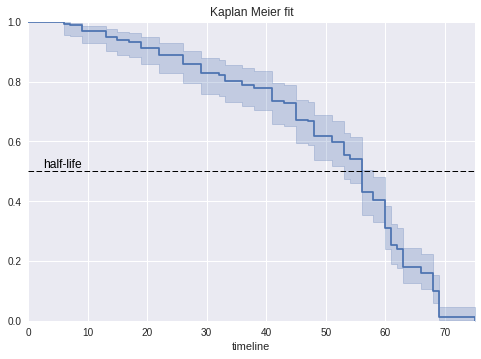

In [26]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons
import os
import sys
#import math
#import struct
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = load_waltons() # returns a Pandas DataFrame
T = df['T']
E = df['E']
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
#plt.show()

km = sa.KaplanMeierFitter()
km.fit(T, event_observed=E)
#print km.data()


x = kmf.survival_function_
#kmf.survival_function_.plot()
ax = km.plot(title="Kaplan Meier fit", legend=False)
ax.annotate('half-life', color='black', xy=(0.01,0.5), xycoords='axes fraction', xytext=(10,4), textcoords='offset points')
ax.axhline(.5, ls='--', lw=1.0, color='black')
ax.set_ylim([0,1])
#ax.set_xlim([0,6])
print km.median_
plt.show()

In [35]:
import inspect
ob = kmf
[method for method in dir(ob)]# if callable(getattr(ob, method))]

      KM_estimate_upper_0.95  KM_estimate_lower_0.95
0.0                      NaN                     NaN
6.0                 0.999134                0.957236
7.0                 0.996918                0.951820
9.0                 0.987071                0.927599
13.0                0.975035                0.903807
15.0                0.966347                0.888423
17.0                0.961858                0.880851
19.0                0.947936                0.858534
22.0                0.928550                0.829531
26.0                0.903344                0.794197
29.0                0.877322                0.759652
32.0                0.872036                0.752823
33.0                0.856034                0.732479
36.0                0.845253                0.719026
38.0                0.834390                0.705656
41.0                0.795782                0.659446
43.0                0.790198                0.652913
45.0                0.739257                0.

In [65]:
s = km.survival_function_
ci = kmf.confidence_interval_
#print s.head()
#print s.columns
#print ci.columns
time = s['KM_estimate'].index
surv = s['KM_estimate'].values
surv_upper = ci['KM_estimate_upper_0.95'].values
surv_lower = ci['KM_estimate_lower_0.95'].values

Float64Index([ 0.0,  6.0,  7.0,  9.0, 13.0, 15.0, 17.0, 19.0, 22.0, 26.0, 29.0,
              32.0, 33.0, 36.0, 38.0, 41.0, 43.0, 45.0, 47.0, 48.0, 51.0, 53.0,
              54.0, 56.0, 58.0, 60.0, 61.0, 62.0, 63.0, 66.0, 68.0, 69.0,
              75.0],
             dtype='float64')
Float64Index([ 0.0,  6.0,  7.0,  9.0, 13.0, 15.0, 17.0, 19.0, 22.0, 26.0, 29.0,
              32.0, 33.0, 36.0, 38.0, 41.0, 43.0, 45.0, 47.0, 48.0, 51.0, 53.0,
              54.0, 56.0, 58.0, 60.0, 61.0, 62.0, 63.0, 66.0, 68.0, 69.0,
              75.0],
             dtype='float64', name=u'timeline')


In [77]:
# Define Bollinger Bands.
#upperband = np.random.random_integers(100, 150, size=100)
#lowerband = upperband - 100
#x_data = np.arange(1, 101)

# Bollinger shading glyph:
band_x = np.append(time, time[::-1])
band_y = np.append(surv_upper, surv_lower[::-1])

#output_file('bollinger.html', title='Bollinger bands (file)')

surv_plt1 = figure(x_axis_type='datetime', title="Survival Analysis")
#surv_plt1.grid.grid_line_alpha = 0.4
surv_plt1.x_range.range_padding = 0

surv_plt1.grid.grid_line_alpha = 0
surv_plt1.xaxis.axis_label = 'Timeline'
#p2.yaxis.axis_label = ' '
#surv_plt1.ygrid.band_fill_color = "grey"
#surv_plt1.ygrid.band_fill_alpha = 0.1
surv_plt1.line(time, surv, legend='avg', color='navy')
surv_plt1.legend.location = "bottom_left"
surv_plt1.plot_height = 500
surv_plt1.plot_width = 700
surv_plt1.patch(band_x, band_y, color='#7570B3', fill_alpha=0.2)

#upper and lower 95% confidence in tervals shown

show(surv_plt1)

KeyboardInterrupt: 